100%|████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 22856.93it/s]


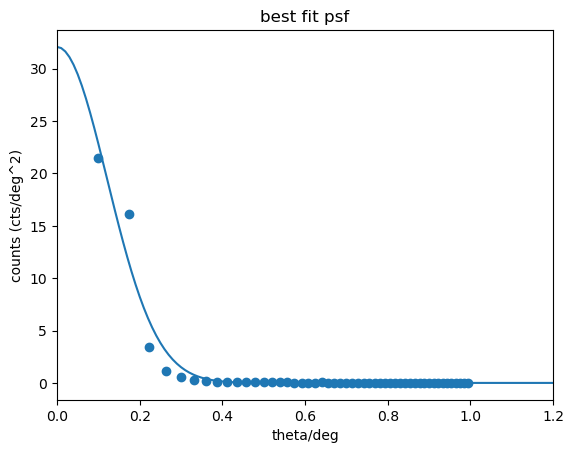

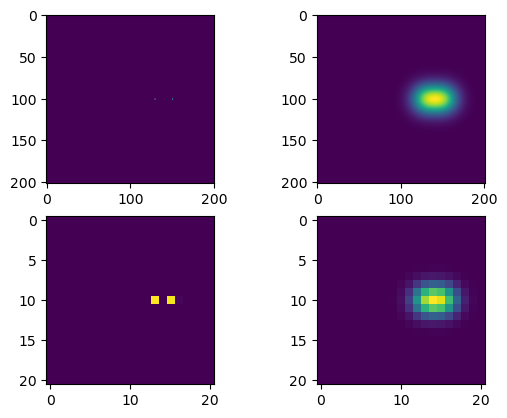

2.00
2.00
2.00
2.00



In [17]:
from scipy.optimize import curve_fit
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit
import tqdm
import scipy



def fitpsf(index,plot=False):
    '''
    Args:
    1. index, an integer, 
        0 : 1.4.txt
        1 : 1.6.txt
        2 : 2.8.txt
        3 : 2.0.txt
        4 : 2.2.txt
        5 : 2.4.txt
        6 : 2.6.txt
        7 : 2.8.txt
        8 : 3.0.txt
        
    Returns:
    1. func, a function for convolution of psf
    '''
    
    
    Data = np.load('psf.npy')
    theta2 = Data[index,:,0]
    value = Data[index,:,1]

    density = np.zeros_like(theta2)
    density[1:-1] = (value[:-2] + value[1:-1]) / (np.pi *(theta2[2:]-theta2[:-2]))
    density[0] = (value[0]+value[1])/(np.pi * theta2[1])
    density[-1] = 0
    theta = np.sqrt(theta2)

    theta_fine = np.linspace(0,1,101)

    import scipy

    def gauss1d(x,sig1,amp1,sig2,amp2):
            return amp1 * 1/(np.sqrt(2 * np.pi)*sig1) * np.exp(-(x)**2/2/sig1**2)+amp2 * 1/(np.sqrt(2 * np.pi)*sig2) * np.exp(-(x)**2/2/sig2**2)

    bestfit,pcov = curve_fit(gauss1d,theta,density)

    
    if plot:
        x = np.linspace(0,2,201)
        plt.figure()
        plt.plot(x,gauss1d(x,*bestfit))
        plt.xlim(0,1.2)
        plt.scatter(theta,density)
        plt.title('best fit psf')
        plt.xlabel('theta/deg')
        plt.ylabel('counts (cts/deg^2)')
        
        
    
    
    def psfconv(src,xx,yy):
        '''
        Args: 
        1. src, sky map containing the source, without PSF
        2. xx,yy:  xx,yy = np.meshgrid(x,y)
        
        Returns: 
        1. the sky map after convolution with PSF
        '''
        summap = np.zeros(src.shape)
        r0 = np.sqrt(xx**2+yy**2)
        tmpmap = gauss1d(r0,*bestfit)
        norm = 1/tmpmap.sum()
        #print('norm %.2f'%norm)
        
        for i in tqdm.trange(src.shape[0]):
            for j in range(src.shape[1]):
                if src[i,j] == 0:
                    continue
                r = np.sqrt((xx-xx[0,j])**2 +(yy-yy[i,0])**2)
                tmpmap = gauss1d(r,*bestfit) * norm * src[i,j]
                #tmpmap = np.where(r > theta[-1] , 0, tmpmap)
                summap += tmpmap
                
        return summap
    return psfconv,bestfit

def bindata(sky,xx,yy,pw):
    '''
    Args: 
    1. sky, sky map being binned
    2. xx, yy
    3. pw, pixel width, in degree
    
    return :
    1. skybin: sky rebinned
    2. xxb,yyb : rebinned coordinate
    '''
    x = xx[0,:]
    y = yy[:,0]
    
    pw_current = (xx.max()-xx.min())/xx.shape[0] #当前像素宽度
    target_width = int((xx.max()-xx.min())/pw)+1#目标数组长宽
    scale_factor = int(xx.shape[0]/target_width)+1#缩放倍数，先将原图插值放大，然后再缩小。这里是中间图到终图的尺寸比例，是整数。
    middle_width = target_width*scale_factor#中间图的尺寸
    scale_factor_mid = (middle_width/xx.shape[0])#从初始到中间的放大系数，需要除掉。
    
    x_mid = np.linspace(xx.min(),xx.max(),middle_width)  #中间坐标
    y_mid = np.linspace(yy.min(),yy.max(),middle_width)
    x_fin = np.linspace(xx.min(),xx.max(),target_width)   #最终坐标
    y_fin = np.linspace(yy.min(),yy.max(),target_width)
    
    xxb,yyb = np.meshgrid(x_fin,y_fin) #最终的二维坐标
    
    finterp = scipy.interpolate.RectBivariateSpline(x,y,sky)
    sky_mid = finterp(x_mid,y_mid)
    
    sky_fin = sky_mid.reshape(target_width,scale_factor,target_width,scale_factor).sum(3).sum(1) /scale_factor_mid**2#除以了因为格子大小而改变的范围
    
    return sky_fin,xxb,yyb


def add_pointsrc(ra,dec,counts,x,y,z):
    '''
    ra, dec: float, location of target point src
    counts:  total counts from that point src
    x,y:     1d array, list of ra and dec of the map
    z:       2d array, counts of the sky region
    
    return: z, sky map with src added
    
    '''
    
    srcx = np.argmin(np.abs(ra-x))
    srcy = np.argmin(np.abs(dec-y))
    z[srcx,srcy] += counts
    return z
    
    
if __name__ == '__main__':
    psfconv,bestfit = fitpsf(7,plot=True)
    x = y = np.linspace(-1,1,201)
    xx,yy = np.meshgrid(x,y)
    z = np.zeros_like(xx)

    z = add_pointsrc(0,0.3,1,x,y,z)
    z = add_pointsrc(0,0.512312,1,x,y,z)
    blurz = psfconv(z,xx,yy)

    zbin,xxb,yyb = bindata(z,xx,yy,0.1) 
    blurzbin,xxb,yyb = bindata(blurz,xx,yy,0.1) 

    fig,ax = plt.subplots(2,2)
    ax[0][0].imshow(z)
    ax[0][1].imshow(blurz)
    ax[1][0].imshow(zbin)
    ax[1][1].imshow(blurzbin)
    plt.show()
    print('%.2f\n%.2f\n%.2f\n%.2f\n'%(zbin.sum(),blurzbin.sum(),z.sum(),blurz.sum()))


In [2]:
x = y = np.linspace(-1,1,21)
xx,yy = np.meshgrid(x,y)
z = np.zeros_like(xx)
z[5,7] = 1
z[5,5] = 1
blurz = psfconv(z,xx,yy)

zbin,xxb,yyb,bp1 = bindata(z,xx,yy,0.05) 
blurzbin,xxb,yyb,bp2 = bindata(blurz,xx,yy,0.05) 
fig,ax = plt.subplots(2,2)
ax[0][0].imshow(z)
ax[0][0].set_title('intrinsic')
ax[0][1].imshow(blurz)
ax[0][0].set_title('PSF')
ax[1][0].imshow(zbin)
ax[0][0].set_title('intrinsic,binned')
ax[1][1].imshow(blurzbin)
ax[0][0].set_title('PSF,binned')
print(zbin.sum(),blurzbin.sum())

100%|█████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 100319.34it/s]


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
import numpy as np
import scipy
import astropy
import matplotlib.pyplot as plt
x = np.linspace(0,10,301)
y = np.linspace(0,10,301)
xx,yy = np.meshgrid(x,y)
z = np.random.rand(xx.shape[0],xx.shape[1])
plt.imshow(z)
plt.colorbar()
plt.figure()
func = scipy.interpolate.RectBivariateSpline(x,y,z)
xnew = np.linspace(0,10,400)
ynew = np.linspace(0,10,400)
xxn,yyn = np.meshgrid(xnew,ynew)
after = func(xnew,ynew.flatten())

fin = after.reshape(100,4,100,4).sum(1).sum(2)/16
plt.imshow(fin)
plt.colorbar()